In [1]:
!nvidia-smi

Wed Dec 17 20:27:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:06:00.0 Off |                    0 |
| N/A   33C    P0             35W /  250W |     475MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Load Modules

In [2]:
import os
import sys
import numpy as np
import xarray as xr
import pyvista as pv
pv.set_jupyter_backend("html")
from cedalion import units
import cedalion
import pickle
import glob 
from pathlib import Path
from pathlib import PureWindowsPath
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path

# %load_ext autoreload
# %autoreload 2
# %matplotlib widget


In [3]:
def max_value_normalize(xarr):
    """
    Normalizes an xarray DataArray by dividing by the maximum absolute value of chromo=0,
    scaling the data into the (-1,1) range.

    Parameters:
        xarr (xarray.DataArray): Input data with chromo x parcel x time dimensions.
    Returns:
        xarray.DataArray: Normalized data in the range (-1,1).
    """
    # Extract chromo=0, HbO
    chromo_0 = xarr[:, :, :] # TODO consider both hbo and hbr. plot distr
    
    # Get the maximum absolute value from chromo=0
    max_val = np.abs(chromo_0).max()

    # Avoid division by zero
    if max_val == 0:
        return xarr  # Return unchanged if max is zero
    
    # Normalize
    normalized = xarr / max_val

    return xr.DataArray(normalized, coords=xarr.coords, dims=xarr.dims), max_val

In [4]:
# Available datasets:
# DATASET_NAME = "BallSqueezingHD_modified"
# DATASET_NAME = "BS_Laura"
DATASET_NAME = "FreshMotor"
# DATASET_NAME = "ElectricalThermal"


PRE_PROCESSED_DIR = Path(f'datasets/preprocessed/{DATASET_NAME}')
preproc_files_path = str(PRE_PROCESSED_DIR / 'ts_all_parcels' / 'sub-*' / '*.pkl')
pkl_files = glob.glob(preproc_files_path)

len(pkl_files), pkl_files[:2]

(40,
 ['datasets/preprocessed/FreshMotor/ts_all_parcels/sub-08/sub-08_task-FRESHMOTOR_run-left2s_nirs_ts_all_parcels.pkl',
  'datasets/preprocessed/FreshMotor/ts_all_parcels/sub-08/sub-08_task-FRESHMOTOR_run-right2s_nirs_ts_all_parcels.pkl'])

In [5]:
PROCESSED_DIR = Path(f'datasets/processed/{DATASET_NAME}')
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Create a templete parcels based on BallSqueezing dataset

In [6]:
if DATASET_NAME == "BallSqueezingHD_modified":
    MAX_PARCELS = 0
    PARCEL_TEMPLATE = None

    for file in pkl_files:
        with open(file, 'rb') as handle:
            data_pickle = pickle.load(handle)        
        timeseries = data_pickle['signal_raw']
        sensitive_parcels = data_pickle['sensitive_parcels']
        
        sensitive_timeseries = timeseries.sel(parcel=sensitive_parcels)
        
        if sensitive_timeseries.sizes["parcel"] > MAX_PARCELS:
            MAX_PARCELS = sensitive_timeseries.sizes["parcel"]
            PARCEL_TEMPLATE = sensitive_timeseries.parcel.values.tolist()
            
    
    print(f"Max parcels across subjects: {MAX_PARCELS}")
    print(f"Parcel template: {PARCEL_TEMPLATE}")

    # Save the template parcels to pkl file
    with open(f'{PROCESSED_DIR}/parcel_template_{DATASET_NAME}.pkl', 'wb') as handle:
        pickle.dump(PARCEL_TEMPLATE, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load Pre-defined template parcel

In [7]:
# Load Pre-defined template parcel from BallSqueezingHD_modified pkl file
with open(f'{PROCESSED_DIR.parents[0]}/BallSqueezingHD_modified/parcel_template_BallSqueezingHD_modified.pkl', 'rb') as handle:
    PARCEL_TEMPLATE = pickle.load(handle)
len(PARCEL_TEMPLATE)

109

# Inspect parcels

## Load files for testing

170, 176, 170, 176, 161, 165, 161, 156, 167, 167, 82, 75, 174, 174, 169, 169, 155, 155, 155, 155, 164, 159, 159, 159, 164, 164, 152, 152, 158, 160, 160, 160, 175, 171, 171, 171, 172, 172, 172, 172, 

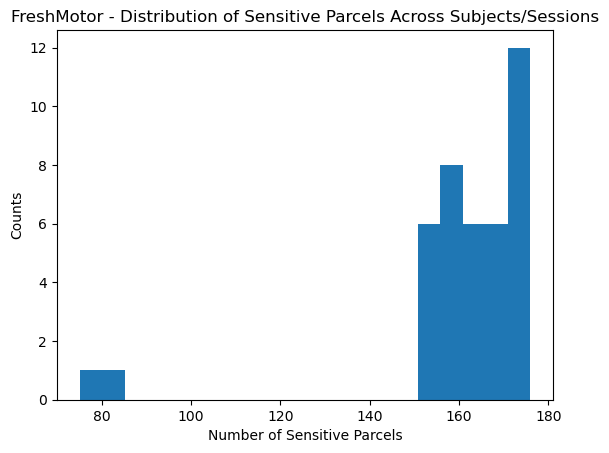

In [8]:
freqs = [0.5, 0.7, 1.0] 
FMAX = freqs[0]
# freq_dir = PROCESSED_DIR / f'frq{0.2}'
# freq_dir.mkdir(exist_ok=True)
    
sensitive_parcels_list = []

for file in pkl_files:
    with open(file, 'rb') as handle:
        data_pickle = pickle.load(handle)
        
    timeseries = data_pickle['signal_raw']
    sensitive_parcels = data_pickle['sensitive_parcels']
    
    sensitive_parcels_list.append(sensitive_parcels)
    
for i in sensitive_parcels_list:
    print(len(i), end=', ')
    
plt.hist([len(i) for i in sensitive_parcels_list], bins=20)
plt.xlabel('Number of Sensitive Parcels')
plt.ylabel('Counts')
plt.title(f'{DATASET_NAME} - Distribution of Sensitive Parcels Across Subjects/Sessions')
plt.savefig(PROCESSED_DIR / f'sensitive_parcels_distribution_{DATASET_NAME}.png', dpi=300)
plt.show()

In [9]:
# load first file
with open(pkl_files[9], 'rb') as handle:
    data_pickle = pickle.load(handle)
    
timeseries = data_pickle['signal_raw']
dropped_parcels = data_pickle['dropped_parcels']
sensitive_parcels = data_pickle['sensitive_parcels']
len(sensitive_parcels), len(dropped_parcels), timeseries.shape

(167, 435, (2, 601, 4332))

### Inspect shape of original parcels and sens_parcels of 1st file

In [10]:
print("timeseries.shape:", timeseries.shape)
print("len(sensitive_parcels):", len(sensitive_parcels))
print("len(PARCEL_TEMPLATE):", len(PARCEL_TEMPLATE))
print("timeseries.sel(parcel=PARCEL_TEMPLATE).shape:", timeseries.sel(parcel=PARCEL_TEMPLATE).shape)

timeseries.shape: (2, 601, 4332)
len(sensitive_parcels): 167
len(PARCEL_TEMPLATE): 109
timeseries.sel(parcel=PARCEL_TEMPLATE).shape: (2, 109, 4332)


In [11]:
signal_raw = timeseries.transpose('parcel', "chromo", "time")
signal_raw = signal_raw.pint.quantify({'time':'seconds'})
signal_raw.sel(chromo='HbO', parcel=PARCEL_TEMPLATE)

<xarray.DataArray (parcel: 109, time: 4332)> Size: 4MB
<Quantity([[ 7.80693330e-02 -4.43770646e-02 -4.07250195e-02 ...  6.59893296e-02
   3.19565558e-01  1.03178834e-01]
 [-1.98711516e-03  3.31907359e-03  8.32653587e-04 ... -1.97886259e-02
  -3.14327475e-02 -1.26727333e-02]
 [ 2.37485918e-02 -4.79207724e-03 -1.29047997e-02 ...  1.38051333e-02
   7.36938412e-02  1.84085414e-02]
 ...
 [-6.60471262e-03  5.45868840e-04 -1.20970208e-02 ... -1.35890137e-02
  -1.87244929e-02 -1.32261355e-02]
 [ 1.03572963e-03  4.35378386e-04  1.11829019e-03 ...  2.77310659e-04
  -1.35660787e-03 -8.99018655e-04]
 [-2.02592451e-02 -1.77723578e-04 -6.87815389e-03 ... -1.88939414e-02
  -4.01793884e-02 -2.65295838e-02]], 'micromolar')>
Coordinates:
    chromo   <U3 12B 'HbO'
  * time     (time) float64 35kB 0.0 0.112 0.224 0.336 ... 484.8 485.0 485.1
    samples  (time) int64 35kB 0 1 2 3 4 5 6 ... 4326 4327 4328 4329 4330 4331
  * parcel   (parcel) object 872B 'ContA_IPS_2_LH' ... 'TempPar_8_LH'

### Inspect ensitive parcels of first file

### Reindex
- filter1: keep only sensitive parcels of that file
- filter2: filter with template parcels
- reindex: zero pad

In [12]:
padded_timeseries = timeseries.sel(parcel=sensitive_parcels).reindex(parcel=PARCEL_TEMPLATE, fill_value=0)

padded_timeseries.shape, padded_timeseries[:, 0, 0].values

((2, 109, 4332), array([ 0.07806933, -0.00864547]))

### Check the template parcels

In [13]:
for i, parcel in enumerate(PARCEL_TEMPLATE):
        print(f"{i}. {parcel}")

0. ContA_IPS_2_LH
1. ContA_IPS_2_RH
2. ContA_IPS_3_LH
3. ContA_IPS_3_RH
4. ContA_PFCd_1_LH
5. ContA_PFCd_2_LH
6. ContA_PFCl_1_LH
7. ContA_PFCl_2_LH
8. ContA_PFCl_2_RH
9. ContA_PFCl_5_RH
10. ContA_PFCl_6_LH
11. ContB_IPL_3_LH
12. ContB_IPL_3_RH
13. ContB_PFCd_1_LH
14. ContB_PFCl_1_LH
15. ContB_PFCld_2_RH
16. ContB_PFCld_3_RH
17. ContB_PFCld_4_RH
18. ContB_PFCld_5_RH
19. ContB_PFCld_6_RH
20. DefaultB_IPL_3_LH
21. DefaultB_PFCl_1_LH
22. DefaultB_PFCl_2_LH
23. DefaultB_Temp_2_RH
24. DefaultB_Temp_5_LH
25. DorsAttnA_SPL_7_RH
26. DorsAttnB_FEF_1_LH
27. DorsAttnB_FEF_1_RH
28. DorsAttnB_FEF_2_RH
29. DorsAttnB_FEF_4_LH
30. DorsAttnB_FEF_4_RH
31. DorsAttnB_PostC_1_LH
32. DorsAttnB_PostC_1_RH
33. DorsAttnB_PostC_2_RH
34. DorsAttnB_PostC_3_LH
35. DorsAttnB_PostC_3_RH
36. DorsAttnB_PostC_4_RH
37. DorsAttnB_PrCv_1_LH
38. DorsAttnB_PrCv_1_RH
39. SalVentAttnA_FrOper_3_LH
40. SalVentAttnA_FrOper_3_RH
41. SalVentAttnA_FrOper_5_RH
42. SalVentAttnA_ParOper_1_RH
43. SalVentAttnA_ParOper_2_LH
44. SalVentAtt

### Before padding: parcels of sensitive parcels of 1st file after before filtering with template parcels

In [14]:
for i, parcel in enumerate(PARCEL_TEMPLATE):
    if parcel in timeseries.sel(parcel=sensitive_parcels).parcel.values.tolist():
        print(f"{i}. {parcel}")
    else:
        print(f"{i}. {'----------------'}")

0. ContA_IPS_2_LH
1. ContA_IPS_2_RH
2. ContA_IPS_3_LH
3. ContA_IPS_3_RH
4. ContA_PFCd_1_LH
5. ContA_PFCd_2_LH
6. ContA_PFCl_1_LH
7. ContA_PFCl_2_LH
8. ContA_PFCl_2_RH
9. ContA_PFCl_5_RH
10. ContA_PFCl_6_LH
11. ContB_IPL_3_LH
12. ContB_IPL_3_RH
13. ContB_PFCd_1_LH
14. ContB_PFCl_1_LH
15. ContB_PFCld_2_RH
16. ContB_PFCld_3_RH
17. ContB_PFCld_4_RH
18. ContB_PFCld_5_RH
19. ContB_PFCld_6_RH
20. DefaultB_IPL_3_LH
21. DefaultB_PFCl_1_LH
22. DefaultB_PFCl_2_LH
23. ----------------
24. ----------------
25. DorsAttnA_SPL_7_RH
26. DorsAttnB_FEF_1_LH
27. DorsAttnB_FEF_1_RH
28. DorsAttnB_FEF_2_RH
29. DorsAttnB_FEF_4_LH
30. DorsAttnB_FEF_4_RH
31. DorsAttnB_PostC_1_LH
32. DorsAttnB_PostC_1_RH
33. DorsAttnB_PostC_2_RH
34. DorsAttnB_PostC_3_LH
35. DorsAttnB_PostC_3_RH
36. DorsAttnB_PostC_4_RH
37. DorsAttnB_PrCv_1_LH
38. DorsAttnB_PrCv_1_RH
39. ----------------
40. ----------------
41. SalVentAttnA_FrOper_5_RH
42. SalVentAttnA_ParOper_1_RH
43. SalVentAttnA_ParOper_2_LH
44. SalVentAttnA_ParOper_3_LH
45. 

### After padding: check parcels of 1st file after padding with template parcels

In [15]:
for i, parcel in enumerate(PARCEL_TEMPLATE):
    if parcel in padded_timeseries.parcel.values.tolist():
        print(f"{i}. {parcel}: {padded_timeseries.sel(parcel=parcel, chromo='HbO').values[0]}")
    else:
        print(f"{i}. {'----------------'}", end="")

0. ContA_IPS_2_LH: 0.07806933296697559
1. ContA_IPS_2_RH: -0.00198711516032162
2. ContA_IPS_3_LH: 0.023748591789199303
3. ContA_IPS_3_RH: 0.0018797145605934777
4. ContA_PFCd_1_LH: -0.0027737800495679084
5. ContA_PFCd_2_LH: -0.0023622735692161037
6. ContA_PFCl_1_LH: -0.0026900838792577367
7. ContA_PFCl_2_LH: -0.013674041787379678
8. ContA_PFCl_2_RH: -0.0021372503603909083
9. ContA_PFCl_5_RH: 0.0073968386659943415
10. ContA_PFCl_6_LH: 0.007412060761191459
11. ContB_IPL_3_LH: 0.06324678035097488
12. ContB_IPL_3_RH: -0.0034833288415379257
13. ContB_PFCd_1_LH: -0.013007305294632452
14. ContB_PFCl_1_LH: -0.0440648254769156
15. ContB_PFCld_2_RH: 0.030804474642995485
16. ContB_PFCld_3_RH: -0.0016357845650308745
17. ContB_PFCld_4_RH: 0.08252593407642729
18. ContB_PFCld_5_RH: 0.020437013329042127
19. ContB_PFCld_6_RH: 0.05964594807508769
20. DefaultB_IPL_3_LH: 0.008323994190109766
21. DefaultB_PFCl_1_LH: -0.0649627774257132
22. DefaultB_PFCl_2_LH: -0.007841828573612803
23. DefaultB_Temp_2_RH: 0.

In [16]:
for i, parcel in enumerate(padded_timeseries.parcel.values.tolist()):
    # get the HbO value at time=0 for this parcel
    v = padded_timeseries.sel(parcel=parcel, chromo='HbO').values[0]
    # make a scalar from array-like results
    try:
        v0 = np.asarray(v).item()
    except Exception:
        v0 = np.asarray(v).ravel()[0]
    # if value is not (close to) zero, print 'keep', otherwise print the numeric value
    display = '-----keep-----' if not np.isclose(v0, 0) else v0
    print(f"{i}. {parcel}: {display}")


0. ContA_IPS_2_LH: -----keep-----
1. ContA_IPS_2_RH: -----keep-----
2. ContA_IPS_3_LH: -----keep-----
3. ContA_IPS_3_RH: -----keep-----
4. ContA_PFCd_1_LH: -----keep-----
5. ContA_PFCd_2_LH: -----keep-----
6. ContA_PFCl_1_LH: -----keep-----
7. ContA_PFCl_2_LH: -----keep-----
8. ContA_PFCl_2_RH: -----keep-----
9. ContA_PFCl_5_RH: -----keep-----
10. ContA_PFCl_6_LH: -----keep-----
11. ContB_IPL_3_LH: -----keep-----
12. ContB_IPL_3_RH: -----keep-----
13. ContB_PFCd_1_LH: -----keep-----
14. ContB_PFCl_1_LH: -----keep-----
15. ContB_PFCld_2_RH: -----keep-----
16. ContB_PFCld_3_RH: -----keep-----
17. ContB_PFCld_4_RH: -----keep-----
18. ContB_PFCld_5_RH: -----keep-----
19. ContB_PFCld_6_RH: -----keep-----
20. DefaultB_IPL_3_LH: -----keep-----
21. DefaultB_PFCl_1_LH: -----keep-----
22. DefaultB_PFCl_2_LH: -----keep-----
23. DefaultB_Temp_2_RH: 0.0
24. DefaultB_Temp_5_LH: 0.0
25. DorsAttnA_SPL_7_RH: -----keep-----
26. DorsAttnB_FEF_1_LH: -----keep-----
27. DorsAttnB_FEF_1_RH: -----keep-----
28

In [17]:
freqs = [0.5, 0.7, 1.0] 

delta = 2.5
n_shifts = 9


if DATASET_NAME == "BallSqueezingHD_modified":
    shifts = np.linspace(-delta, delta, n_shifts)
elif DATASET_NAME == "FreshMotor":
    shifts = np.linspace(-delta, 0, n_shifts)

print(shifts)
print(np.diff(shifts))
print(np.diff(shifts)*data_pickle['fs'])

# For BSQ-HD where the trial length is 5s, we shift the segments 9 times around the stimulus onset by [-2.5, 2.5] (Difference between the start of the shifted segements is 0.625s)
# Now for FreshMotor where trial duration is 2s, we want to use shift by [2.5, 0]. Does that mean that we still want fix the same number of shifts to 9 (more overlap between segments) as in BSQ-HD dataset wich leads to xxx?
# or we want to fix the same distance between the windows we to to stay as 0.625s which means we shift the signal 4 times only?

# Since the duration of the signals we are interested in is short, the first option makes more sense to me. 

[-2.5    -2.1875 -1.875  -1.5625 -1.25   -0.9375 -0.625  -0.3125  0.    ]
[0.3125 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125]
[2.8125 2.8125 2.8125 2.8125 2.8125 2.8125 2.8125 2.8125]


# Plot row signal

0. ContA_IPS_2_LH: --- KEEP ---
1. ContA_IPS_2_RH: --- KEEP ---
2. ContA_IPS_3_LH: --- KEEP ---
3. ContA_IPS_3_RH: --- KEEP ---
4. ContA_PFCd_1_LH: --- KEEP ---
5. ContA_PFCd_2_LH: --- KEEP ---
6. ContA_PFCl_1_LH: --- KEEP ---
7. ContA_PFCl_2_LH: --- KEEP ---
8. ContA_PFCl_2_RH: --- KEEP ---
9. ContA_PFCl_5_RH: --- KEEP ---
10. ContA_PFCl_6_LH: --- KEEP ---
11. ContB_IPL_3_LH: --- KEEP ---
12. ContB_IPL_3_RH: --- KEEP ---
13. ContB_PFCd_1_LH: --- KEEP ---
14. ContB_PFCl_1_LH: --- KEEP ---
15. ContB_PFCld_2_RH: --- KEEP ---
16. ContB_PFCld_3_RH: --- KEEP ---
17. ContB_PFCld_4_RH: --- KEEP ---
18. ContB_PFCld_5_RH: --- KEEP ---
19. ContB_PFCld_6_RH: --- KEEP ---
20. DefaultB_IPL_3_LH: --- KEEP ---
21. DefaultB_PFCl_1_LH: --- KEEP ---
22. DefaultB_PFCl_2_LH: --- KEEP ---
23. DefaultB_Temp_2_RH: 0.0
24. DefaultB_Temp_5_LH: 0.0
25. DorsAttnA_SPL_7_RH: --- KEEP ---
26. DorsAttnB_FEF_1_LH: --- KEEP ---
27. DorsAttnB_FEF_1_RH: --- KEEP ---
28. DorsAttnB_FEF_2_RH: --- KEEP ---
29. DorsAttnB_FEF

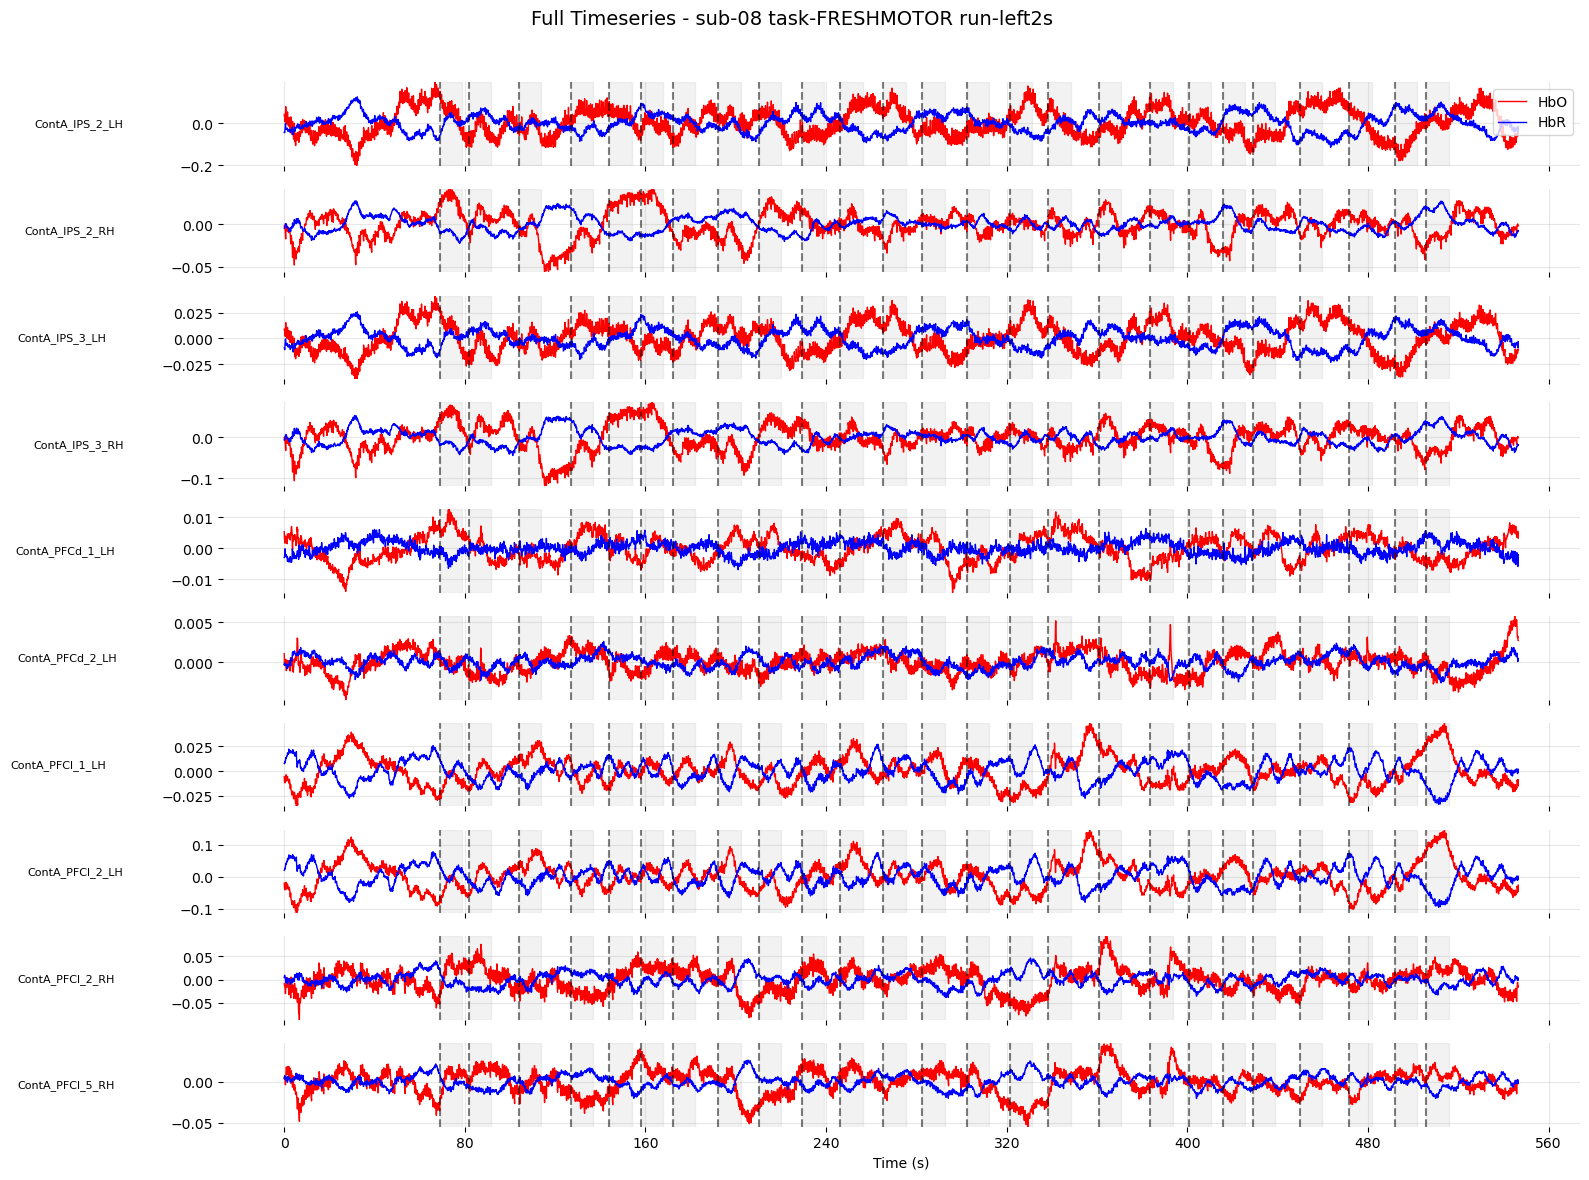

In [18]:
subject_idx = 0
with open(pkl_files[subject_idx], 'rb') as handle:
    data_pickle = pickle.load(handle)

timeseries = data_pickle['signal_raw']
dropped_parcels = data_pickle['dropped_parcels']
sensitive_parcels = data_pickle['sensitive_parcels']
len(sensitive_parcels), len(dropped_parcels), timeseries.shape


def _to_numpy(value):
    if hasattr(value, 'to_numpy'):
        return value.to_numpy()
    return np.asarray(value)

# -------------------------------------------------------------
# Raw HbO + HbR parcel signals (true amplitude)
# Subplots touching, individual Y-axis scales, transparent frame
# -------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

NUM_PARCELS_TO_PLOT = min(10, len(sensitive_parcels))

def _to_numpy(value):
    if hasattr(value, 'to_numpy'):
        return value.to_numpy()
    return np.asarray(value)

stim = data_pickle['stim']
stim_onsets = _to_numpy(stim['onset'])
stim_labels = _to_numpy(stim['trial_type'])
stim_durations = _to_numpy(stim['duration'])

# -------------------------------------------------------------
# Preprocessing
# -------------------------------------------------------------
signal_raw = data_pickle['signal_raw']

signal = cedalion.sigproc.frequency.freq_filter(
    signal_raw,
    0.008 * units.Hz,
    FMAX * units.Hz,
    4
)

# timeseries, _ = cedalion.sigproc.physio.global_component_subtract(
#     ts=signal, k=0, spatial_dim='parcel', spectral_dim='chromo'
# )

# NOTE: raw amplitude (no normalization)
timeseries = timeseries.sel(parcel=sensitive_parcels).reindex(parcel=PARCEL_TEMPLATE, fill_value=0)



for i, parcel in enumerate(timeseries.parcel.values.tolist()):
    v = timeseries.sel(parcel=parcel, chromo='HbO').values[0]
    try:
        v0 = np.asarray(v).item()
    except Exception:
        v0 = np.asarray(v).ravel()[0]
    # display = 'KEEP' if not np.isclose(v0, 0) else v0
    display = '--- KEEP ---' if not v0 == 0 else v0
    
    print(f"{i}. {parcel}: {display}")
    
    
    
    
parcel_subset = PARCEL_TEMPLATE[:NUM_PARCELS_TO_PLOT]

# Time axis
try:
    time_axis = timeseries.time.as_numpy()
except:
    time_axis = np.arange(timeseries.shape[-1])

# -------------------------------------------------------------
# Subplots with INDIVIDUAL y-axis scales per parcel
# -------------------------------------------------------------
fig, axes = plt.subplots(
    NUM_PARCELS_TO_PLOT,
    1,
    figsize=(16, 12),
    sharex=True,
    sharey=False        # <<< IMPORTANT: disable shared amplitude
)

if NUM_PARCELS_TO_PLOT == 1:
    axes = [axes]

# Touching subplots
plt.subplots_adjust(hspace=0.0)
fig.subplots_adjust(top=0.96, bottom=0.06, left=0.12, right=0.98)

# -------------------------------------------------------------
# Plot each parcel
# -------------------------------------------------------------
colors = {"HbO": "red", "HbR": "blue"}

for ax, parcel in zip(axes, parcel_subset):

    trace_hbo = timeseries.sel(parcel=parcel).isel(chromo=0).as_numpy()
    trace_hbr = timeseries.sel(parcel=parcel).isel(chromo=1).as_numpy()

    # Plot raw signals (no scaling)
    ax.plot(time_axis, trace_hbo, color=colors["HbO"], linewidth=1)
    ax.plot(time_axis, trace_hbr, color=colors["HbR"], linewidth=1)

    # Parcel label
    ax.set_ylabel(
        str(parcel),
        fontsize=8,
        rotation=0,
        labelpad=40,
        ha='right',
        va='center'
    )

    # Stimulus markers
    if stim_onsets.size > 0:
        for onset in stim_onsets:
            ax.axvline(onset, color='black', linestyle='--', alpha=0.5)
    if stim_onsets.size > 0 and stim_durations.size > 0:
        for onset, duration in zip(stim_onsets, stim_durations):
            ax.axvspan(onset, onset + duration, color='gray', alpha=0.1)

    # *** INDIVIDUAL local y-axis ***
    local_min = min(trace_hbo.min(), trace_hbr.min())
    local_max = max(trace_hbo.max(), trace_hbr.max())
    ax.set_ylim(local_min, local_max)

    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(MaxNLocator(10))

    # Transparent frame (remove axis box)
    for spine in ax.spines.values():
        spine.set_visible(False)

# Bottom subplot gets x-label only
axes[-1].set_xlabel("Time (s)")

# Legend appears once
axes[0].legend(['HbO', 'HbR'], loc='upper right')

fig.suptitle(
    f"Full Timeseries - {pkl_files[subject_idx].split('/')[-1].split('.')[0].replace('_', ' ').replace('nirs ts all parcels', '')}",
    fontsize=14
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(PROCESSED_DIR / f'full_timeseries_individual_yaxis_{DATASET_NAME}_{pkl_files[subject_idx].split("/")[-1].split(".")[0]}.png', dpi=300)
plt.show()

# Create segmentation

In [19]:
# segment_sh_conc_pcr[:, :, :TIME_SEGMENT].shape # (2, 68, 90) <- freshmotor
# segment_sh_conc_pcr[:, :, :TIME_SEGMENT].shape # (2, 100, 90) <- BSQ-HD

In [ ]:

INDEX = 0
for FMAX in freqs:
    print(f'Processing frequency: {FMAX} Hz')
    freq_dir = PROCESSED_DIR / f'frq{FMAX}'
    freq_dir.mkdir(exist_ok=True)
    
    subject_to_rec = {}
    for file in pkl_files:
        print(f'Processing file: {file}')
        with open(file, 'rb') as handle:
            data_pickle = pickle.load(handle)
            
        signal_raw = data_pickle['signal_raw']
        conc_pcr_raw = data_pickle['conc_pcr']
        dropped_parcels = data_pickle['dropped_parcels']
        sensitive_parcels = data_pickle['sensitive_parcels']
        stim = data_pickle['stim']
        label = data_pickle['label']
        
        fs = float(data_pickle['fs'])
        TIME_SEGMENT = int(round(fs * stim['duration'][0])) # assuming all trials in the session have the same duration

        # bandpass filter
        # 
        signal = cedalion.sigproc.frequency.freq_filter(
            signal_raw,
            0.01 * units.Hz,
            FMAX * units.Hz,
            4
        )
        
        conc_pcr = cedalion.sigproc.frequency.freq_filter(
            conc_pcr_raw,
            0.01 * units.Hz,
            FMAX * units.Hz,
            4
        )

        # phy-removal within the parcel-dimension
        # timeseries, _ = cedalion.sigproc.physio.global_component_subtract(ts=signal, k=0 ,spatial_dim='parcel',spectral_dim='chromo')
        
        # normalize
        timeseries, norm_factor = max_value_normalize(signal)
        timeseries_conc_pcr, norm_factor_conc_pcr = max_value_normalize(conc_pcr)
        
        # Pad timeseries to have consistent parcel dimension
        timeseries = timeseries.sel(parcel=sensitive_parcels).reindex(parcel=PARCEL_TEMPLATE, fill_value=0)

        # extract meta information
        data = timeseries.as_numpy()
        data_conc_pcr = timeseries_conc_pcr.as_numpy()
        
        time = timeseries.time.as_numpy()

        reference = np.zeros(time.shape[0])
        SUB = PureWindowsPath(file).parts[-2]
        if SUB not in subject_to_rec:
            subject_to_rec[SUB] = []
        try:
            sub_dir = Path(freq_dir) / SUB
            sub_dir.mkdir(parents=True, exist_ok=True)
        except FileExistsError:
            pass
        
        # create segments
        for onset, du, ty in zip(stim['onset'], stim['duration'], stim['trial_type']):

            # update the reference with correct labels
            onset_idx = int(round(onset * fs))
            duration_samples = int(round(du * fs))
            reference[onset_idx:onset_idx + duration_samples] = label[ty]
            
            mylist = []
            # shift the data to generate more samples
            for delta_ in shifts:
                shift_samples = int(round(delta_ * fs))
                start_idx = onset_idx + shift_samples
                end_idx = start_idx + TIME_SEGMENT
                if start_idx < 0 or end_idx > data.shape[-1]:
                    continue
                segment_sh = data[:, :, start_idx:end_idx]
                segment_sh_conc_pcr = data_conc_pcr[:, :, start_idx:end_idx]
                
                ref_segment = reference[start_idx:end_idx]

                # save files
                filename = r'{}/{}/event_{}_delta{:+.2f}_{}.pkl'.format(freq_dir, SUB, 'aug' if delta_ != 0.0 else 'orig', delta_, INDEX)
                subject_to_rec[SUB].append(filename)
                INDEX += 1
                print(filename)
                
                # dataset information            
                segment_data = {
                    'xt': segment_sh[:, :, :TIME_SEGMENT],
                    'xt_conc_pcr': segment_sh_conc_pcr[:, :, :TIME_SEGMENT],
                    'ref': ref_segment[:TIME_SEGMENT],
                    'class': label[ty],
                    'file': file,
                    'norm_factor': float(norm_factor),
                    'norm_factor_conc_pcr': float(norm_factor_conc_pcr),
                    'parcel_template': PARCEL_TEMPLATE,
                    'TIME_SEGMENT': TIME_SEGMENT
                }
                mylist.append(segment_data)

                with open(filename, 'wb') as handle:
                    pickle.dump(segment_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('{}/meta_event_{}.pkl'.format(freq_dir, FMAX), 'wb') as handle:
        pickle.dump(subject_to_rec, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Done!')

Processing frequency: 0.5 Hz
Processing file: datasets/preprocessed/FreshMotor/ts_all_parcels/sub-08/sub-08_task-FRESHMOTOR_run-left2s_nirs_ts_all_parcels.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.50_0.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.19_1.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.88_2.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.56_3.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.25_4.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.94_5.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.62_6.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.31_7.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_orig_delta+0.00_8.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.50_9.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.19_10.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delt

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.50_36.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.19_37.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.88_38.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.56_39.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.25_40.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.94_41.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.62_42.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.31_43.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_orig_delta+0.00_44.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.50_45.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.19_46.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.88_47.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.56_48.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.2

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.31_268.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_orig_delta+0.00_269.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.50_270.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.19_271.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.88_272.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.56_273.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.25_274.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.94_275.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.62_276.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.31_277.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_orig_delta+0.00_278.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.50_279.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.19_280.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-08/event_orig_delta+0.00_539.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.50_540.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.19_541.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.88_542.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.56_543.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.25_544.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.94_545.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.62_546.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.31_547.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_orig_delta+0.00_548.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.50_549.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.19_550.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.88_551.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.56_768.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.25_769.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.94_770.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.62_771.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.31_772.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_orig_delta+0.00_773.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.50_774.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-2.19_775.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.88_776.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.56_777.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-1.25_778.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.94_779.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_aug_delta-0.62_780.pkl
datasets/processed/FreshMotor/frq0.5/sub-08/event_

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-2.19_1009.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.88_1010.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.56_1011.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.25_1012.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.94_1013.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.62_1014.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.31_1015.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_orig_delta+0.00_1016.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-2.50_1017.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-2.19_1018.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.88_1019.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.56_1020.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.25_1021.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-04/event_orig_delta+0.00_1259.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-2.50_1260.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-2.19_1261.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.88_1262.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.56_1263.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.25_1264.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.94_1265.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.62_1266.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.31_1267.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_orig_delta+0.00_1268.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-2.50_1269.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-2.19_1270.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.88_1271.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.94_1535.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.62_1536.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.31_1537.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_orig_delta+0.00_1538.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-2.50_1539.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-2.19_1540.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.88_1541.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.56_1542.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.25_1543.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.94_1544.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.62_1545.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.31_1546.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_orig_delta+0.00_1547.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-2.19_1756.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.88_1757.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.56_1758.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.25_1759.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.94_1760.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.62_1761.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-0.31_1762.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_orig_delta+0.00_1763.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-2.50_1764.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-2.19_1765.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.88_1766.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.56_1767.pkl
datasets/processed/FreshMotor/frq0.5/sub-04/event_aug_delta-1.25_1768.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-2.50_2007.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-2.19_2008.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.88_2009.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.56_2010.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.25_2011.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.94_2012.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.62_2013.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.31_2014.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_orig_delta+0.00_2015.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-2.50_2016.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-2.19_2017.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.88_2018.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.56_2019.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.25_2218.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.94_2219.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.62_2220.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.31_2221.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_orig_delta+0.00_2222.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-2.50_2223.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-2.19_2224.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.88_2225.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.56_2226.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.25_2227.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.94_2228.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.62_2229.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.31_2230.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.88_2414.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.56_2415.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.25_2416.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.94_2417.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.62_2418.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.31_2419.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_orig_delta+0.00_2420.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-2.50_2421.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-2.19_2422.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.88_2423.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.56_2424.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.25_2425.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.94_2426.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.56_2685.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.25_2686.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.94_2687.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.62_2688.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.31_2689.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_orig_delta+0.00_2690.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-2.50_2691.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-2.19_2692.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.88_2693.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.56_2694.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-1.25_2695.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.94_2696.pkl
datasets/processed/FreshMotor/frq0.5/sub-06/event_aug_delta-0.62_2697.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.88_2909.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.56_2910.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.25_2911.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.94_2912.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.62_2913.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.31_2914.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_orig_delta+0.00_2915.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-2.50_2916.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-2.19_2917.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.88_2918.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.56_2919.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.25_2920.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.94_2921.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.25_3190.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.94_3191.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.62_3192.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.31_3193.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_orig_delta+0.00_3194.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-2.50_3195.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-2.19_3196.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.88_3197.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.56_3198.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.25_3199.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.94_3200.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.62_3201.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.31_3202.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-03/event_orig_delta+0.00_3464.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-2.50_3465.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-2.19_3466.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.88_3467.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.56_3468.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.25_3469.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.94_3470.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.62_3471.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.31_3472.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_orig_delta+0.00_3473.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-2.50_3474.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-2.19_3475.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.88_3476.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-03/event_orig_delta+0.00_3680.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-2.50_3681.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-2.19_3682.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.88_3683.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.56_3684.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.25_3685.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.94_3686.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.62_3687.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-0.31_3688.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_orig_delta+0.00_3689.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-2.50_3690.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-2.19_3691.pkl
datasets/processed/FreshMotor/frq0.5/sub-03/event_aug_delta-1.88_3692.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.31_3913.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_orig_delta+0.00_3914.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-2.50_3915.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-2.19_3916.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.88_3917.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.56_3918.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.25_3919.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.94_3920.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.62_3921.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.31_3922.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_orig_delta+0.00_3923.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-2.50_3924.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-2.19_3925.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.31_4147.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_orig_delta+0.00_4148.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-2.50_4149.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-2.19_4150.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.88_4151.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.56_4152.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.25_4153.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.94_4154.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.62_4155.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.31_4156.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_orig_delta+0.00_4157.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-2.50_4158.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-2.19_4159.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.56_4368.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.25_4369.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.94_4370.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.62_4371.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.31_4372.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_orig_delta+0.00_4373.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-2.50_4374.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-2.19_4375.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.88_4376.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.56_4377.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.25_4378.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.94_4379.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.62_4380.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.25_4648.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.94_4649.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.62_4650.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.31_4651.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_orig_delta+0.00_4652.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-2.50_4653.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-2.19_4654.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.88_4655.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.56_4656.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-1.25_4657.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.94_4658.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.62_4659.pkl
datasets/processed/FreshMotor/frq0.5/sub-09/event_aug_delta-0.31_4660.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-2.50_4914.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-2.19_4915.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.88_4916.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.56_4917.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.25_4918.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.94_4919.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.62_4920.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.31_4921.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_orig_delta+0.00_4922.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-2.50_4923.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-2.19_4924.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.88_4925.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.56_4926.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-07/event_orig_delta+0.00_5120.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-2.50_5121.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-2.19_5122.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.88_5123.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.56_5124.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.25_5125.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.94_5126.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.62_5127.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.31_5128.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_orig_delta+0.00_5129.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-2.50_5130.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-2.19_5131.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.88_5132.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.56_5367.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.25_5368.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.94_5369.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.62_5370.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.31_5371.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_orig_delta+0.00_5372.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-2.50_5373.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-2.19_5374.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.88_5375.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.56_5376.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.25_5377.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.94_5378.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.62_5379.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.56_5637.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.25_5638.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.94_5639.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.62_5640.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.31_5641.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_orig_delta+0.00_5642.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-2.50_5643.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-2.19_5644.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.88_5645.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.56_5646.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-1.25_5647.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.94_5648.pkl
datasets/processed/FreshMotor/frq0.5/sub-07/event_aug_delta-0.62_5649.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-02/event_orig_delta+0.00_5903.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.50_5904.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.19_5905.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.88_5906.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.56_5907.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.25_5908.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.94_5909.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.62_5910.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.31_5911.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_orig_delta+0.00_5912.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.50_5913.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.19_5914.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.88_5915.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.56_6132.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.25_6133.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.94_6134.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.62_6135.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.31_6136.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_orig_delta+0.00_6137.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.50_6138.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.19_6139.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.88_6140.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.56_6141.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.25_6142.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.94_6143.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.62_6144.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.62_6351.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.31_6352.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_orig_delta+0.00_6353.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.50_6354.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.19_6355.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.88_6356.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.56_6357.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.25_6358.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.94_6359.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.62_6360.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.31_6361.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_orig_delta+0.00_6362.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.50_6363.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-02/event_orig_delta+0.00_6623.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.50_6624.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.19_6625.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.88_6626.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.56_6627.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.25_6628.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.94_6629.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.62_6630.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-0.31_6631.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_orig_delta+0.00_6632.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.50_6633.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-2.19_6634.pkl
datasets/processed/FreshMotor/frq0.5/sub-02/event_aug_delta-1.88_6635.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.56_6897.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.25_6898.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.94_6899.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.62_6900.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.31_6901.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_orig_delta+0.00_6902.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-2.50_6903.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-2.19_6904.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.88_6905.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.56_6906.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.25_6907.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.94_6908.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.62_6909.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-2.19_7120.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.88_7121.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.56_7122.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.25_7123.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.94_7124.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.62_7125.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.31_7126.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_orig_delta+0.00_7127.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-2.50_7128.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-2.19_7129.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.88_7130.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.56_7131.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.25_7132.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.94_7394.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.62_7395.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.31_7396.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_orig_delta+0.00_7397.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-2.50_7398.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-2.19_7399.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.88_7400.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.56_7401.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.25_7402.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.94_7403.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.62_7404.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.31_7405.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_orig_delta+0.00_7406.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-2.19_7615.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.88_7616.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.56_7617.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.25_7618.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.94_7619.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.62_7620.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-0.31_7621.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_orig_delta+0.00_7622.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-2.50_7623.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-2.19_7624.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.88_7625.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.56_7626.pkl
datasets/processed/FreshMotor/frq0.5/sub-01/event_aug_delta-1.25_7627.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.25_7870.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.94_7871.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.62_7872.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.31_7873.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_orig_delta+0.00_7874.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-2.50_7875.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-2.19_7876.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.88_7877.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.56_7878.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.25_7879.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.94_7880.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.62_7881.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.31_7882.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.31_8161.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_orig_delta+0.00_8162.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-2.50_8163.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-2.19_8164.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.88_8165.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.56_8166.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.25_8167.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.94_8168.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.62_8169.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.31_8170.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_orig_delta+0.00_8171.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-2.50_8172.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-2.19_8173.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.94_8393.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.62_8394.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.31_8395.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_orig_delta+0.00_8396.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-2.50_8397.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-2.19_8398.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.88_8399.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.56_8400.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.25_8401.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.94_8402.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.62_8403.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.31_8404.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_orig_delta+0.00_8405.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.31_8665.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_orig_delta+0.00_8666.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-2.50_8667.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-2.19_8668.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.88_8669.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.56_8670.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-1.25_8671.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.94_8672.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.62_8673.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-0.31_8674.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_orig_delta+0.00_8675.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-2.50_8676.pkl
datasets/processed/FreshMotor/frq0.5/sub-05/event_aug_delta-2.19_8677.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.88_8849.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.56_8850.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.25_8851.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.94_8852.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.62_8853.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.31_8854.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_orig_delta+0.00_8855.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-2.50_8856.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-2.19_8857.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.88_8858.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.56_8859.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.25_8860.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.94_8861.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-10/event_orig_delta+0.00_9089.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-2.50_9090.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-2.19_9091.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.88_9092.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.56_9093.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.25_9094.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.94_9095.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.62_9096.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.31_9097.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_orig_delta+0.00_9098.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-2.50_9099.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-2.19_9100.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.88_9101.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-2.19_9361.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.88_9362.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.56_9363.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.25_9364.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.94_9365.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.62_9366.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.31_9367.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_orig_delta+0.00_9368.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-2.50_9369.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-2.19_9370.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.88_9371.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.56_9372.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.25_9373.pkl
datasets/processed/FreshMotor/frq0.5/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.94_9644.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.62_9645.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.31_9646.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_orig_delta+0.00_9647.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-2.50_9648.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-2.19_9649.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.88_9650.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.56_9651.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-1.25_9652.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.94_9653.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.62_9654.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_aug_delta-0.31_9655.pkl
datasets/processed/FreshMotor/frq0.5/sub-10/event_orig_delta+0.00_9656.pkl
datasets/processed/FreshMotor/frq0.5

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.50_9855.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.19_9856.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.88_9857.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.56_9858.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.25_9859.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.94_9860.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.62_9861.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.31_9862.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_orig_delta+0.00_9863.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.50_9864.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.19_9865.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.88_9866.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.56_9867.pkl
datasets/processed/FreshMotor/frq0.7/

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.56_10083.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.25_10084.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.94_10085.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.62_10086.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.31_10087.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_orig_delta+0.00_10088.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.50_10089.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.19_10090.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.88_10091.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.56_10092.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.25_10093.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.94_10094.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.62_10095.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.62_10356.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.31_10357.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_orig_delta+0.00_10358.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.50_10359.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.19_10360.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.88_10361.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.56_10362.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.25_10363.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.94_10364.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.62_10365.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.31_10366.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_orig_delta+0.00_10367.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.50_10368.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.31_10582.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_orig_delta+0.00_10583.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.50_10584.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.19_10585.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.88_10586.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.56_10587.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-1.25_10588.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.94_10589.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.62_10590.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-0.31_10591.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_orig_delta+0.00_10592.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.50_10593.pkl
datasets/processed/FreshMotor/frq0.7/sub-08/event_aug_delta-2.19_10594.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.88_10829.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.56_10830.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.25_10831.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.94_10832.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.62_10833.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.31_10834.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_orig_delta+0.00_10835.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-2.50_10836.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-2.19_10837.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.88_10838.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.56_10839.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.25_10840.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.94_10841.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.31_11086.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_orig_delta+0.00_11087.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-2.50_11088.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-2.19_11089.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.88_11090.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.56_11091.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.25_11092.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.94_11093.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.62_11094.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.31_11095.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_orig_delta+0.00_11096.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-2.50_11097.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-2.19_11098.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.62_11355.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.31_11356.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_orig_delta+0.00_11357.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-2.50_11358.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-2.19_11359.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.88_11360.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.56_11361.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.25_11362.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.94_11363.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.62_11364.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.31_11365.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_orig_delta+0.00_11366.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-2.50_11367.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.56_11577.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.25_11578.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.94_11579.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.62_11580.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.31_11581.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_orig_delta+0.00_11582.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-2.50_11583.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-2.19_11584.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.88_11585.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.56_11586.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-1.25_11587.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.94_11588.pkl
datasets/processed/FreshMotor/frq0.7/sub-04/event_aug_delta-0.62_11589.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.31_11842.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_orig_delta+0.00_11843.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-2.50_11844.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-2.19_11845.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.88_11846.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.56_11847.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.25_11848.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.94_11849.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.62_11850.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.31_11851.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_orig_delta+0.00_11852.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-2.50_11853.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-2.19_11854.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.25_12028.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.94_12029.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.62_12030.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.31_12031.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_orig_delta+0.00_12032.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-2.50_12033.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-2.19_12034.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.88_12035.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.56_12036.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.25_12037.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.94_12038.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.62_12039.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.31_12040.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-2.50_12213.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-2.19_12214.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.88_12215.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.56_12216.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.25_12217.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.94_12218.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.62_12219.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.31_12220.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_orig_delta+0.00_12221.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-2.50_12222.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-2.19_12223.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.88_12224.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.56_12225.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.56_12504.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.25_12505.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.94_12506.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.62_12507.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.31_12508.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_orig_delta+0.00_12509.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-2.50_12510.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-2.19_12511.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.88_12512.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.56_12513.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-1.25_12514.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.94_12515.pkl
datasets/processed/FreshMotor/frq0.7/sub-06/event_aug_delta-0.62_12516.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-03/event_orig_delta+0.00_12716.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.50_12717.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.19_12718.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.88_12719.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.56_12720.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.25_12721.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.94_12722.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.62_12723.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.31_12724.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_orig_delta+0.00_12725.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.50_12726.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.19_12727.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.88_12728.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.31_13012.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_orig_delta+0.00_13013.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.50_13014.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.19_13015.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.88_13016.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.56_13017.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.25_13018.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.94_13019.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.62_13020.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.31_13021.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_orig_delta+0.00_13022.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.50_13023.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.19_13024.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.31_13282.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_orig_delta+0.00_13283.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.50_13284.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.19_13285.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.88_13286.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.56_13287.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.25_13288.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.94_13289.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.62_13290.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.31_13291.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_orig_delta+0.00_13292.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.50_13293.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.19_13294.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.25_13495.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.94_13496.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.62_13497.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.31_13498.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_orig_delta+0.00_13499.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.50_13500.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-2.19_13501.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.88_13502.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.56_13503.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-1.25_13504.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.94_13505.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.62_13506.pkl
datasets/processed/FreshMotor/frq0.7/sub-03/event_aug_delta-0.31_13507.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-09/event_orig_delta+0.00_13715.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.50_13716.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.19_13717.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.88_13718.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.56_13719.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.25_13720.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.94_13721.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.62_13722.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.31_13723.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_orig_delta+0.00_13724.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.50_13725.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.19_13726.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.88_13727.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.62_13965.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.31_13966.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_orig_delta+0.00_13967.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.50_13968.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.19_13969.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.88_13970.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.56_13971.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.25_13972.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.94_13973.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.62_13974.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.31_13975.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_orig_delta+0.00_13976.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.50_13977.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.31_14191.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_orig_delta+0.00_14192.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.50_14193.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.19_14194.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.88_14195.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.56_14196.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.25_14197.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.94_14198.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.62_14199.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.31_14200.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_orig_delta+0.00_14201.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.50_14202.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.19_14203.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.31_14461.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_orig_delta+0.00_14462.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.50_14463.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.19_14464.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.88_14465.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.56_14466.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-1.25_14467.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.94_14468.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.62_14469.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-0.31_14470.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_orig_delta+0.00_14471.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.50_14472.pkl
datasets/processed/FreshMotor/frq0.7/sub-09/event_aug_delta-2.19_14473.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.25_14692.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.94_14693.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.62_14694.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.31_14695.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_orig_delta+0.00_14696.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-2.50_14697.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-2.19_14698.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.88_14699.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.56_14700.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.25_14701.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.94_14702.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.62_14703.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.31_14704.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.94_14954.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.62_14955.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.31_14956.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_orig_delta+0.00_14957.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-2.50_14958.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-2.19_14959.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.88_14960.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.56_14961.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.25_14962.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.94_14963.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.62_14964.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.31_14965.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_orig_delta+0.00_14966.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.94_15188.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.62_15189.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.31_15190.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_orig_delta+0.00_15191.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-2.50_15192.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-2.19_15193.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.88_15194.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.56_15195.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.25_15196.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.94_15197.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.62_15198.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.31_15199.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_orig_delta+0.00_15200.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.88_15455.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.56_15456.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.25_15457.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.94_15458.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.62_15459.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.31_15460.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_orig_delta+0.00_15461.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-2.50_15462.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-2.19_15463.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.88_15464.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.56_15465.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-1.25_15466.pkl
datasets/processed/FreshMotor/frq0.7/sub-07/event_aug_delta-0.94_15467.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.62_15729.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.31_15730.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_orig_delta+0.00_15731.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-2.50_15732.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-2.19_15733.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.88_15734.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.56_15735.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.25_15736.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.94_15737.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.62_15738.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.31_15739.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_orig_delta+0.00_15740.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-2.50_15741.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-02/event_orig_delta+0.00_15956.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-2.50_15957.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-2.19_15958.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.88_15959.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.56_15960.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.25_15961.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.94_15962.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.62_15963.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.31_15964.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_orig_delta+0.00_15965.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-2.50_15966.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-2.19_15967.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.88_15968.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.62_16170.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.31_16171.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_orig_delta+0.00_16172.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-2.50_16173.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-2.19_16174.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.88_16175.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.56_16176.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.25_16177.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.94_16178.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.62_16179.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.31_16180.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_orig_delta+0.00_16181.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-2.50_16182.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.94_16448.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.62_16449.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.31_16450.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_orig_delta+0.00_16451.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-2.50_16452.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-2.19_16453.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.88_16454.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.56_16455.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-1.25_16456.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.94_16457.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.62_16458.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_aug_delta-0.31_16459.pkl
datasets/processed/FreshMotor/frq0.7/sub-02/event_orig_delta+0.00_16460.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-01/event_orig_delta+0.00_16694.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.50_16695.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.19_16696.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.88_16697.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.56_16698.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.25_16699.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.94_16700.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.62_16701.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.31_16702.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_orig_delta+0.00_16703.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.50_16704.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.19_16705.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.88_16706.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.62_16944.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.31_16945.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_orig_delta+0.00_16946.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.50_16947.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.19_16948.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.88_16949.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.56_16950.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.25_16951.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.94_16952.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.62_16953.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.31_16954.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_orig_delta+0.00_16955.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.50_16956.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.94_17204.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.62_17205.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.31_17206.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_orig_delta+0.00_17207.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.50_17208.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.19_17209.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.88_17210.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.56_17211.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.25_17212.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.94_17213.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.62_17214.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.31_17215.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_orig_delta+0.00_17216.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.50_17433.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.19_17434.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.88_17435.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.56_17436.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.25_17437.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.94_17438.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.62_17439.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-0.31_17440.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_orig_delta+0.00_17441.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.50_17442.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-2.19_17443.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.88_17444.pkl
datasets/processed/FreshMotor/frq0.7/sub-01/event_aug_delta-1.56_17445.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-05/event_orig_delta+0.00_17702.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-2.50_17703.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-2.19_17704.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.88_17705.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.56_17706.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.25_17707.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.94_17708.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.62_17709.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.31_17710.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_orig_delta+0.00_17711.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-2.50_17712.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-2.19_17713.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.88_17714.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.25_17977.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.94_17978.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.62_17979.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.31_17980.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_orig_delta+0.00_17981.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-2.50_17982.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-2.19_17983.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.88_17984.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.56_17985.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.25_17986.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.94_17987.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.62_17988.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.31_17989.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.31_18205.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_orig_delta+0.00_18206.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-2.50_18207.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-2.19_18208.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.88_18209.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.56_18210.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.25_18211.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.94_18212.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.62_18213.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.31_18214.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_orig_delta+0.00_18215.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-2.50_18216.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-2.19_18217.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.25_18481.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.94_18482.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.62_18483.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.31_18484.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_orig_delta+0.00_18485.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-2.50_18486.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-2.19_18487.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.88_18488.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.56_18489.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-1.25_18490.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.94_18491.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.62_18492.pkl
datasets/processed/FreshMotor/frq0.7/sub-05/event_aug_delta-0.31_18493.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.88_18686.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.56_18687.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.25_18688.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.94_18689.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.62_18690.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.31_18691.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_orig_delta+0.00_18692.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-2.50_18693.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-2.19_18694.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.88_18695.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.56_18696.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.25_18697.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.94_18698.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-2.50_18918.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-2.19_18919.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.88_18920.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.56_18921.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.25_18922.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.94_18923.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.62_18924.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.31_18925.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_orig_delta+0.00_18926.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-2.50_18927.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-2.19_18928.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.88_18929.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.56_18930.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-2.19_19171.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.88_19172.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.56_19173.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.25_19174.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.94_19175.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.62_19176.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.31_19177.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_orig_delta+0.00_19178.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-2.50_19179.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-2.19_19180.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.88_19181.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.56_19182.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.25_19183.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.56_19452.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.25_19453.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.94_19454.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.62_19455.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.31_19456.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_orig_delta+0.00_19457.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-2.50_19458.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-2.19_19459.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.88_19460.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.56_19461.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-1.25_19462.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.94_19463.pkl
datasets/processed/FreshMotor/frq0.7/sub-10/event_aug_delta-0.62_19464.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.25_19687.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.94_19688.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.62_19689.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.31_19690.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_orig_delta+0.00_19691.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-2.50_19692.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-2.19_19693.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.88_19694.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.56_19695.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.25_19696.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.94_19697.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.62_19698.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.31_19699.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.25_19903.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.94_19904.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.62_19905.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.31_19906.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_orig_delta+0.00_19907.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-2.50_19908.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-2.19_19909.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.88_19910.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.56_19911.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.25_19912.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.94_19913.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.62_19914.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.31_19915.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-08/event_orig_delta+0.00_20177.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-2.50_20178.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-2.19_20179.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.88_20180.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.56_20181.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.25_20182.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.94_20183.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.62_20184.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.31_20185.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_orig_delta+0.00_20186.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-2.50_20187.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-2.19_20188.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.88_20189.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-08/event_orig_delta+0.00_20402.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-2.50_20403.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-2.19_20404.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.88_20405.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.56_20406.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.25_20407.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.94_20408.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.62_20409.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-0.31_20410.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_orig_delta+0.00_20411.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-2.50_20412.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-2.19_20413.pkl
datasets/processed/FreshMotor/frq1.0/sub-08/event_aug_delta-1.88_20414.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-04/event_orig_delta+0.00_20672.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-2.50_20673.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-2.19_20674.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.88_20675.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.56_20676.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.25_20677.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.94_20678.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.62_20679.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.31_20680.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_orig_delta+0.00_20681.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-2.50_20682.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-2.19_20683.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.88_20684.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-2.19_20890.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.88_20891.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.56_20892.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.25_20893.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.94_20894.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.62_20895.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.31_20896.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_orig_delta+0.00_20897.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-2.50_20898.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-2.19_20899.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.88_20900.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.56_20901.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.25_20902.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-2.19_21169.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.88_21170.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.56_21171.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.25_21172.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.94_21173.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.62_21174.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.31_21175.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_orig_delta+0.00_21176.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-2.50_21177.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-2.19_21178.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.88_21179.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.56_21180.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.25_21181.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.25_21370.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.94_21371.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.62_21372.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.31_21373.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_orig_delta+0.00_21374.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-2.50_21375.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-2.19_21376.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.88_21377.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.56_21378.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-1.25_21379.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.94_21380.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.62_21381.pkl
datasets/processed/FreshMotor/frq1.0/sub-04/event_aug_delta-0.31_21382.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.56_21630.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.25_21631.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.94_21632.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.62_21633.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.31_21634.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_orig_delta+0.00_21635.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-2.50_21636.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-2.19_21637.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.88_21638.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.56_21639.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.25_21640.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.94_21641.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.62_21642.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-2.50_21825.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-2.19_21826.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.88_21827.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.56_21828.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.25_21829.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.94_21830.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.62_21831.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.31_21832.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_orig_delta+0.00_21833.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-2.50_21834.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-2.19_21835.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.88_21836.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.56_21837.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.94_22055.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.62_22056.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.31_22057.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_orig_delta+0.00_22058.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-2.50_22059.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-2.19_22060.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.88_22061.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.56_22062.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.25_22063.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.94_22064.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.62_22065.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.31_22066.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_orig_delta+0.00_22067.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.56_22323.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.25_22324.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.94_22325.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.62_22326.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.31_22327.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_orig_delta+0.00_22328.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-2.50_22329.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-2.19_22330.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.88_22331.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.56_22332.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-1.25_22333.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.94_22334.pkl
datasets/processed/FreshMotor/frq1.0/sub-06/event_aug_delta-0.62_22335.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.88_22520.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.56_22521.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.25_22522.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.94_22523.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.62_22524.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.31_22525.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_orig_delta+0.00_22526.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-2.50_22527.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-2.19_22528.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.88_22529.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.56_22530.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.25_22531.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.94_22532.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.88_22835.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.56_22836.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.25_22837.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.94_22838.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.62_22839.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.31_22840.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_orig_delta+0.00_22841.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-2.50_22842.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-2.19_22843.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.88_22844.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.56_22845.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.25_22846.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.94_22847.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.31_23110.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_orig_delta+0.00_23111.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-2.50_23112.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-2.19_23113.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.88_23114.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.56_23115.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.25_23116.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.94_23117.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.62_23118.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.31_23119.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_orig_delta+0.00_23120.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-2.50_23121.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-2.19_23122.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-2.19_23311.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.88_23312.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.56_23313.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.25_23314.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.94_23315.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.62_23316.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-0.31_23317.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_orig_delta+0.00_23318.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-2.50_23319.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-2.19_23320.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.88_23321.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.56_23322.pkl
datasets/processed/FreshMotor/frq1.0/sub-03/event_aug_delta-1.25_23323.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-2.50_23526.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-2.19_23527.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.88_23528.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.56_23529.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.25_23530.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.94_23531.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.62_23532.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.31_23533.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_orig_delta+0.00_23534.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-2.50_23535.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-2.19_23536.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.88_23537.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.56_23538.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.25_23791.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.94_23792.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.62_23793.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.31_23794.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_orig_delta+0.00_23795.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-2.50_23796.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-2.19_23797.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.88_23798.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.56_23799.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.25_23800.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.94_23801.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.62_23802.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.31_23803.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.94_24017.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.62_24018.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.31_24019.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_orig_delta+0.00_24020.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-2.50_24021.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-2.19_24022.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.88_24023.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.56_24024.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.25_24025.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.94_24026.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.62_24027.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.31_24028.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_orig_delta+0.00_24029.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.62_24279.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.31_24280.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_orig_delta+0.00_24281.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-2.50_24282.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-2.19_24283.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.88_24284.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.56_24285.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-1.25_24286.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.94_24287.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.62_24288.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-0.31_24289.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_orig_delta+0.00_24290.pkl
datasets/processed/FreshMotor/frq1.0/sub-09/event_aug_delta-2.50_24291.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.31_24550.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_orig_delta+0.00_24551.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-2.50_24552.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-2.19_24553.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.88_24554.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.56_24555.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.25_24556.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.94_24557.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.62_24558.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.31_24559.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_orig_delta+0.00_24560.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-2.50_24561.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-2.19_24562.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.94_24764.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.62_24765.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.31_24766.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_orig_delta+0.00_24767.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-2.50_24768.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-2.19_24769.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.88_24770.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.56_24771.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.25_24772.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.94_24773.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.62_24774.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.31_24775.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_orig_delta+0.00_24776.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-2.19_25003.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.88_25004.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.56_25005.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.25_25006.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.94_25007.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.62_25008.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.31_25009.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_orig_delta+0.00_25010.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-2.50_25011.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-2.19_25012.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.88_25013.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.56_25014.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.25_25015.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.88_25274.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.56_25275.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.25_25276.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.94_25277.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.62_25278.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.31_25279.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_orig_delta+0.00_25280.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-2.50_25281.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-2.19_25282.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.88_25283.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.56_25284.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-1.25_25285.pkl
datasets/processed/FreshMotor/frq1.0/sub-07/event_aug_delta-0.94_25286.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-2.50_25515.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-2.19_25516.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.88_25517.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.56_25518.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.25_25519.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.94_25520.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.62_25521.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.31_25522.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_orig_delta+0.00_25523.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-2.50_25524.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-2.19_25525.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.88_25526.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.56_25527.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.88_25733.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.56_25734.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.25_25735.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.94_25736.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.62_25737.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.31_25738.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_orig_delta+0.00_25739.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-2.50_25740.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-2.19_25741.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.88_25742.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.56_25743.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.25_25744.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.94_25745.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.56_25995.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.25_25996.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.94_25997.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.62_25998.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.31_25999.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_orig_delta+0.00_26000.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-2.50_26001.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-2.19_26002.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.88_26003.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.56_26004.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.25_26005.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.94_26006.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.62_26007.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.31_26233.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_orig_delta+0.00_26234.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-2.50_26235.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-2.19_26236.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.88_26237.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.56_26238.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-1.25_26239.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.94_26240.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.62_26241.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-0.31_26242.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_orig_delta+0.00_26243.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-2.50_26244.pkl
datasets/processed/FreshMotor/frq1.0/sub-02/event_aug_delta-2.19_26245.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.62_26529.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.31_26530.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_orig_delta+0.00_26531.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-2.50_26532.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-2.19_26533.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.88_26534.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.56_26535.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.25_26536.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.94_26537.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.62_26538.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.31_26539.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_orig_delta+0.00_26540.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-2.50_26541.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-2.19_26758.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.88_26759.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.56_26760.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.25_26761.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.94_26762.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.62_26763.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.31_26764.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_orig_delta+0.00_26765.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-2.50_26766.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-2.19_26767.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.88_26768.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.56_26769.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.25_26770.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.62_27024.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.31_27025.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_orig_delta+0.00_27026.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-2.50_27027.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-2.19_27028.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.88_27029.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.56_27030.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.25_27031.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.94_27032.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.62_27033.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.31_27034.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_orig_delta+0.00_27035.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-2.50_27036.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.56_27246.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.25_27247.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.94_27248.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.62_27249.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.31_27250.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_orig_delta+0.00_27251.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-2.50_27252.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-2.19_27253.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.88_27254.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.56_27255.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-1.25_27256.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.94_27257.pkl
datasets/processed/FreshMotor/frq1.0/sub-01/event_aug_delta-0.62_27258.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.94_27500.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.62_27501.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.31_27502.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_orig_delta+0.00_27503.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-2.50_27504.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-2.19_27505.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.88_27506.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.56_27507.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.25_27508.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.94_27509.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.62_27510.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.31_27511.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_orig_delta+0.00_27512.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.94_27779.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.62_27780.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.31_27781.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_orig_delta+0.00_27782.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-2.50_27783.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-2.19_27784.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.88_27785.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.56_27786.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.25_27787.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.94_27788.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.62_27789.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.31_27790.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_orig_delta+0.00_27791.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-2.19_28027.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.88_28028.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.56_28029.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.25_28030.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.94_28031.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.62_28032.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.31_28033.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_orig_delta+0.00_28034.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-2.50_28035.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-2.19_28036.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.88_28037.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.56_28038.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.25_28039.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.56_28299.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.25_28300.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.94_28301.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.62_28302.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.31_28303.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_orig_delta+0.00_28304.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-2.50_28305.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-2.19_28306.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.88_28307.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.56_28308.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-1.25_28309.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.94_28310.pkl
datasets/processed/FreshMotor/frq1.0/sub-05/event_aug_delta-0.62_28311.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-2.19_28486.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.88_28487.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.56_28488.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.25_28489.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.94_28490.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.62_28491.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.31_28492.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_orig_delta+0.00_28493.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-2.50_28494.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-2.19_28495.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.88_28496.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.56_28497.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.25_28498.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.25_28705.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.94_28706.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.62_28707.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.31_28708.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_orig_delta+0.00_28709.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-2.50_28710.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-2.19_28711.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.88_28712.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.56_28713.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.25_28714.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.94_28715.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.62_28716.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.31_28717.pkl
datasets/processed/Fresh

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-10/event_orig_delta+0.00_29006.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-2.50_29007.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-2.19_29008.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.88_29009.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.56_29010.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.25_29011.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.94_29012.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.62_29013.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.31_29014.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_orig_delta+0.00_29015.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-2.50_29016.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-2.19_29017.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.88_29018.pkl
datasets/processed/Fres

/opt/conda/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:315: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.88_29279.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.56_29280.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.25_29281.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.94_29282.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.62_29283.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.31_29284.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_orig_delta+0.00_29285.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-2.50_29286.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-2.19_29287.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.88_29288.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.56_29289.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-1.25_29290.pkl
datasets/processed/FreshMotor/frq1.0/sub-10/event_aug_delta-0.94_29291.pkl
datasets/processed/Fresh

# Save event files

In [21]:
if recreate_segments:
    events = "datasets/processed/{}/frq{}/meta_event_{}.pkl"
        
    meta_events = []
    for freq in freqs:
        with open(events.format(DATASET_NAME, freq, freq), 'rb') as handle:
            meta = pickle.load(handle)
        meta_events.append(meta)


    if DATASET_NAME == "BallSqueezingHD_modified":
        session_to_files = {'run-1':[],
                            'run-2':[],
                            'run-3':[]}
        
    elif DATASET_NAME == "FreshMotor":    
        session_to_files = {'run-left2s':[],
                            'run-right2s':[],
                            'run-left3s':[],
                            'run-right3s':[]}

    files_to_session = {}
    for meta_event in meta_events:
        for sub in meta_event:
            for file in meta_event[sub]:
                meta = None
                with open(file, 'rb') as handle:
                    meta = pickle.load(handle) 
                run = meta['file'].split('_')[-5]
                files_to_session[file] = run
                session_to_files[run].append(file)

    for run in session_to_files:
        print(run, len(session_to_files[run]))

    # this will save the mapping of files to sessions used for LOSO
    with open(f'datasets/processed/{DATASET_NAME}/files_to_sessions.pkl', 'wb') as handle:
        pickle.dump(files_to_session, handle, protocol=pickle.HIGHEST_PROTOCOL)     
    print("Saved files_to_sessions.pkl")

run-left2s 6669
run-right2s 8019
run-left3s 6669
run-right3s 8100
Saved files_to_sessions.pkl


In [22]:
FMAX = 0.5
freq_dir = Path(PROCESSED_DIR / f'frq{FMAX}')
recursive = True

if recursive:
    n = sum(1 for _ in freq_dir.rglob('*.pkl'))
else:
    n = sum(1 for _ in freq_dir.glob('*.pkl'))
print(n) 

9820


In [23]:
segment_count = sum(1 for _ in freq_dir.rglob('*') if _.is_file())
segment_count

9820

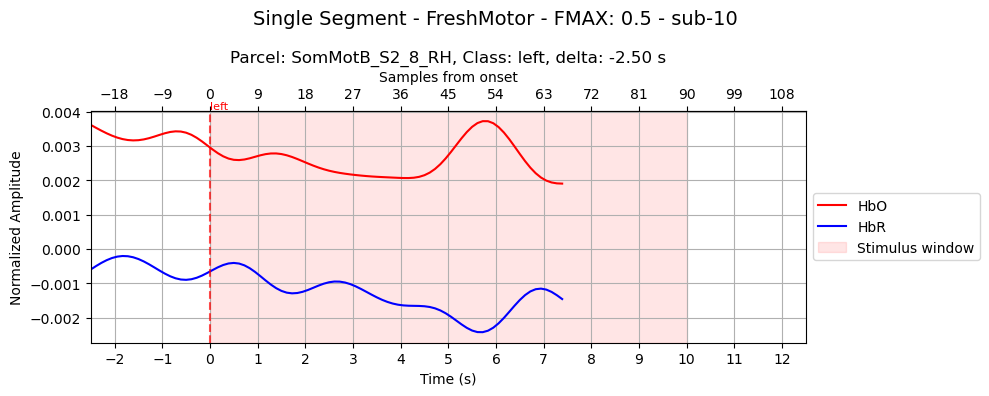

In [26]:
# -------------------------------------------------------------
# Inspect a single saved segment and overlay stimulus events
# -------------------------------------------------------------
FMAX = 0.5
subject_id = "sub-10" if DATASET_NAME == "FreshMotor" else "sub-177"
freq_dir = Path(PROCESSED_DIR / f'frq{FMAX}')
if DATASET_NAME == "FreshMotor":
    sample_file = freq_dir / subject_id / 'event_aug_delta-2.50_9666.pkl'
elif DATASET_NAME == "BallSqueezingHD_modified":
    sample_file = freq_dir / subject_id / 'event_aug_delta+0.62_4021.pkl'
import re
from matplotlib.ticker import MultipleLocator
with open(sample_file, 'rb') as handle:
    segment_data = pickle.load(handle)

xt = np.asarray(segment_data['xt'])
ref = np.asarray(segment_data['ref'])
class_label = segment_data['class']
label_map = {
    1: 'right',
    2: 'left'
}
class_name = label_map.get(class_label, str(class_label))
file = segment_data['file']
norm_factor = segment_data['norm_factor']
parcel_template = segment_data['parcel_template']
TIME_SEGMENT = segment_data['TIME_SEGMENT']

with open(file, 'rb') as handle:
    original_data = pickle.load(handle)
fs = float(original_data['fs'])
trial_duration = TIME_SEGMENT / fs

delta_match = re.search(r'delta([+-]?\d+\.\d+)', sample_file.name)
delta_value = float(delta_match.group(1)) if delta_match else 0.0

parcel_idx = 100  # Change this index to plot different parcels
sample_axis = np.arange(TIME_SEGMENT)
time_axis = delta_value + sample_axis / fs

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_axis, xt[0, parcel_idx, :], label='HbO', color='red')
ax.plot(time_axis, xt[1, parcel_idx, :], label='HbR', color='blue')

stim_onset = 0.0
stim_offset = trial_duration
ax.axvspan(stim_onset, stim_offset, color='red', alpha=0.1, label='Stimulus window')
ax.axvline(stim_onset, color='red', linestyle='--', alpha=0.7)
ax.text(stim_onset, ax.get_ylim()[1], class_name, color='red', fontsize=8, verticalalignment='bottom')

fig.suptitle(f'Single Segment - {DATASET_NAME} - FMAX: {FMAX} - {subject_id}', fontsize=14),
ax.set_title(f'Parcel: {parcel_template[parcel_idx]}, Class: {class_name}, delta: {delta_value:+.2f} s')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized Amplitude')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.grid(True)
pad = abs(delta_value)
ax.set_xlim(-pad, trial_duration + pad)
secax = ax.secondary_xaxis('top', functions=(lambda t: t * fs, lambda s: s / fs))
secax.set_xlabel('Samples from onset')
secax.xaxis.set_major_locator(MultipleLocator(fs))

plt.tight_layout()
plt.savefig(PROCESSED_DIR / f'single_segment_{DATASET_NAME}_{sample_file.stem}_parcel{parcel_idx}.png', dpi=300)
plt.show()


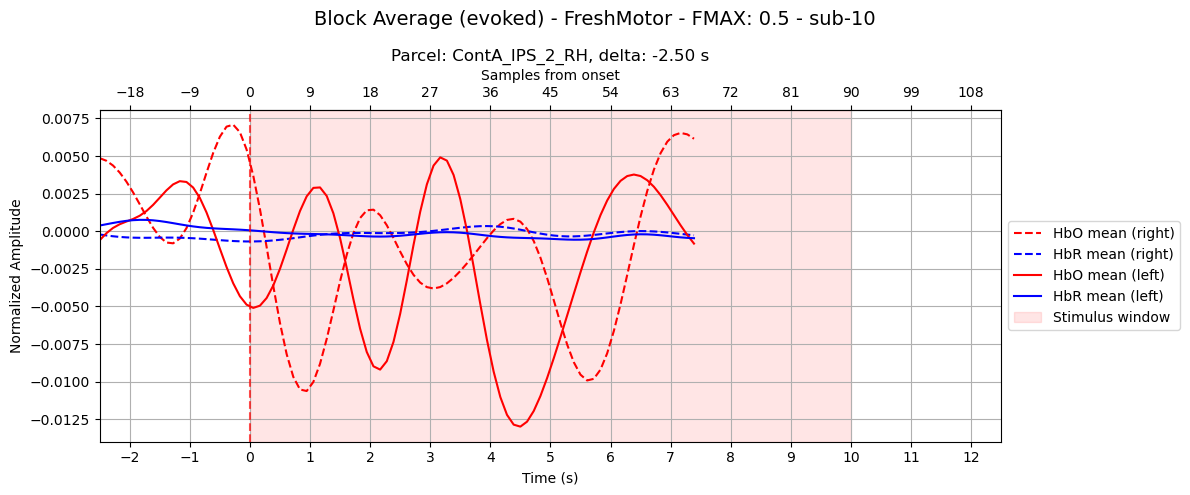

In [27]:
# -------------------------------------------------------------
# Block-averaged evoked response per class for a given delta
# -------------------------------------------------------------
# FMAX = 0.5
# subject_id = 'sub-02' #'sub-177'
target_delta = -2.5 # seconds
parcel_idx = 1
freq_dir = Path(PROCESSED_DIR / f'frq{FMAX}')
delta_tag = f"delta{target_delta:+.2f}"
segment_files = sorted((freq_dir / subject_id).glob(f'event_*_{delta_tag}_*.pkl'))
if not segment_files:
    raise ValueError(f'No segments found for delta {target_delta} in {subject_id}')

label_map = {1: 'right', 2: 'left'}
segments_by_class = {k: [] for k in label_map}
fs = None
parcel_template = None
TIME_SEGMENT = None
for seg_path in segment_files:
    with open(seg_path, 'rb') as handle:
        seg = pickle.load(handle)
    class_id = seg['class']
    if class_id not in segments_by_class:
        continue
    if fs is None:
        with open(seg['file'], 'rb') as handle:
            orig = pickle.load(handle)
        fs = float(orig['fs'])
        TIME_SEGMENT = seg['TIME_SEGMENT']
        parcel_template = seg['parcel_template']
    segments_by_class[class_id].append(seg['xt'][parcel_idx, :, :])

trial_duration = TIME_SEGMENT / fs
sample_axis = np.arange(TIME_SEGMENT)
fig, ax = plt.subplots(figsize=(12, 5))
pad = abs(target_delta)
for class_id, traces in segments_by_class.items():
    if not traces:
        continue
    traces = np.stack(traces)
    hbO_mean = traces[:, 0, :].mean(axis=0)
    hbR_mean = traces[:, 1, :].mean(axis=0)
    time_axis = target_delta + sample_axis / fs
    if class_id == 1:
        line_style = '--'
    elif class_id == 2:
        line_style = '-'
    else:
        line_style = ':'
    ax.plot(time_axis, hbO_mean, label=f"HbO mean ({label_map[class_id]})", color='red', linestyle=line_style)
    ax.plot(time_axis, hbR_mean, label=f"HbR mean ({label_map[class_id]})", color='blue', linestyle=line_style)

ax.axvspan(0.0, trial_duration, color='red', alpha=0.1, label='Stimulus window')
ax.axvline(0.0, color='red', linestyle='--', alpha=0.7)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized Amplitude')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5) )
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.grid(True)
ax.set_xlim(-pad, trial_duration + pad)
secax = ax.secondary_xaxis('top', functions=(lambda t: t * fs, lambda s: s / fs))
secax.set_xlabel('Samples from onset')
secax.xaxis.set_major_locator(MultipleLocator(fs))
fig.suptitle(f'Block Average (evoked) - {DATASET_NAME} - FMAX: {FMAX} - {subject_id}', fontsize=14)
ax.set_title(f'Parcel: {parcel_template[parcel_idx]}, delta: {target_delta:+.2f} s')
plt.tight_layout()
plt.savefig(PROCESSED_DIR / f'block_average_evoked_{DATASET_NAME}_{subject_id}_parcel{parcel_idx}_{delta_tag}.png', dpi=300)
plt.show()


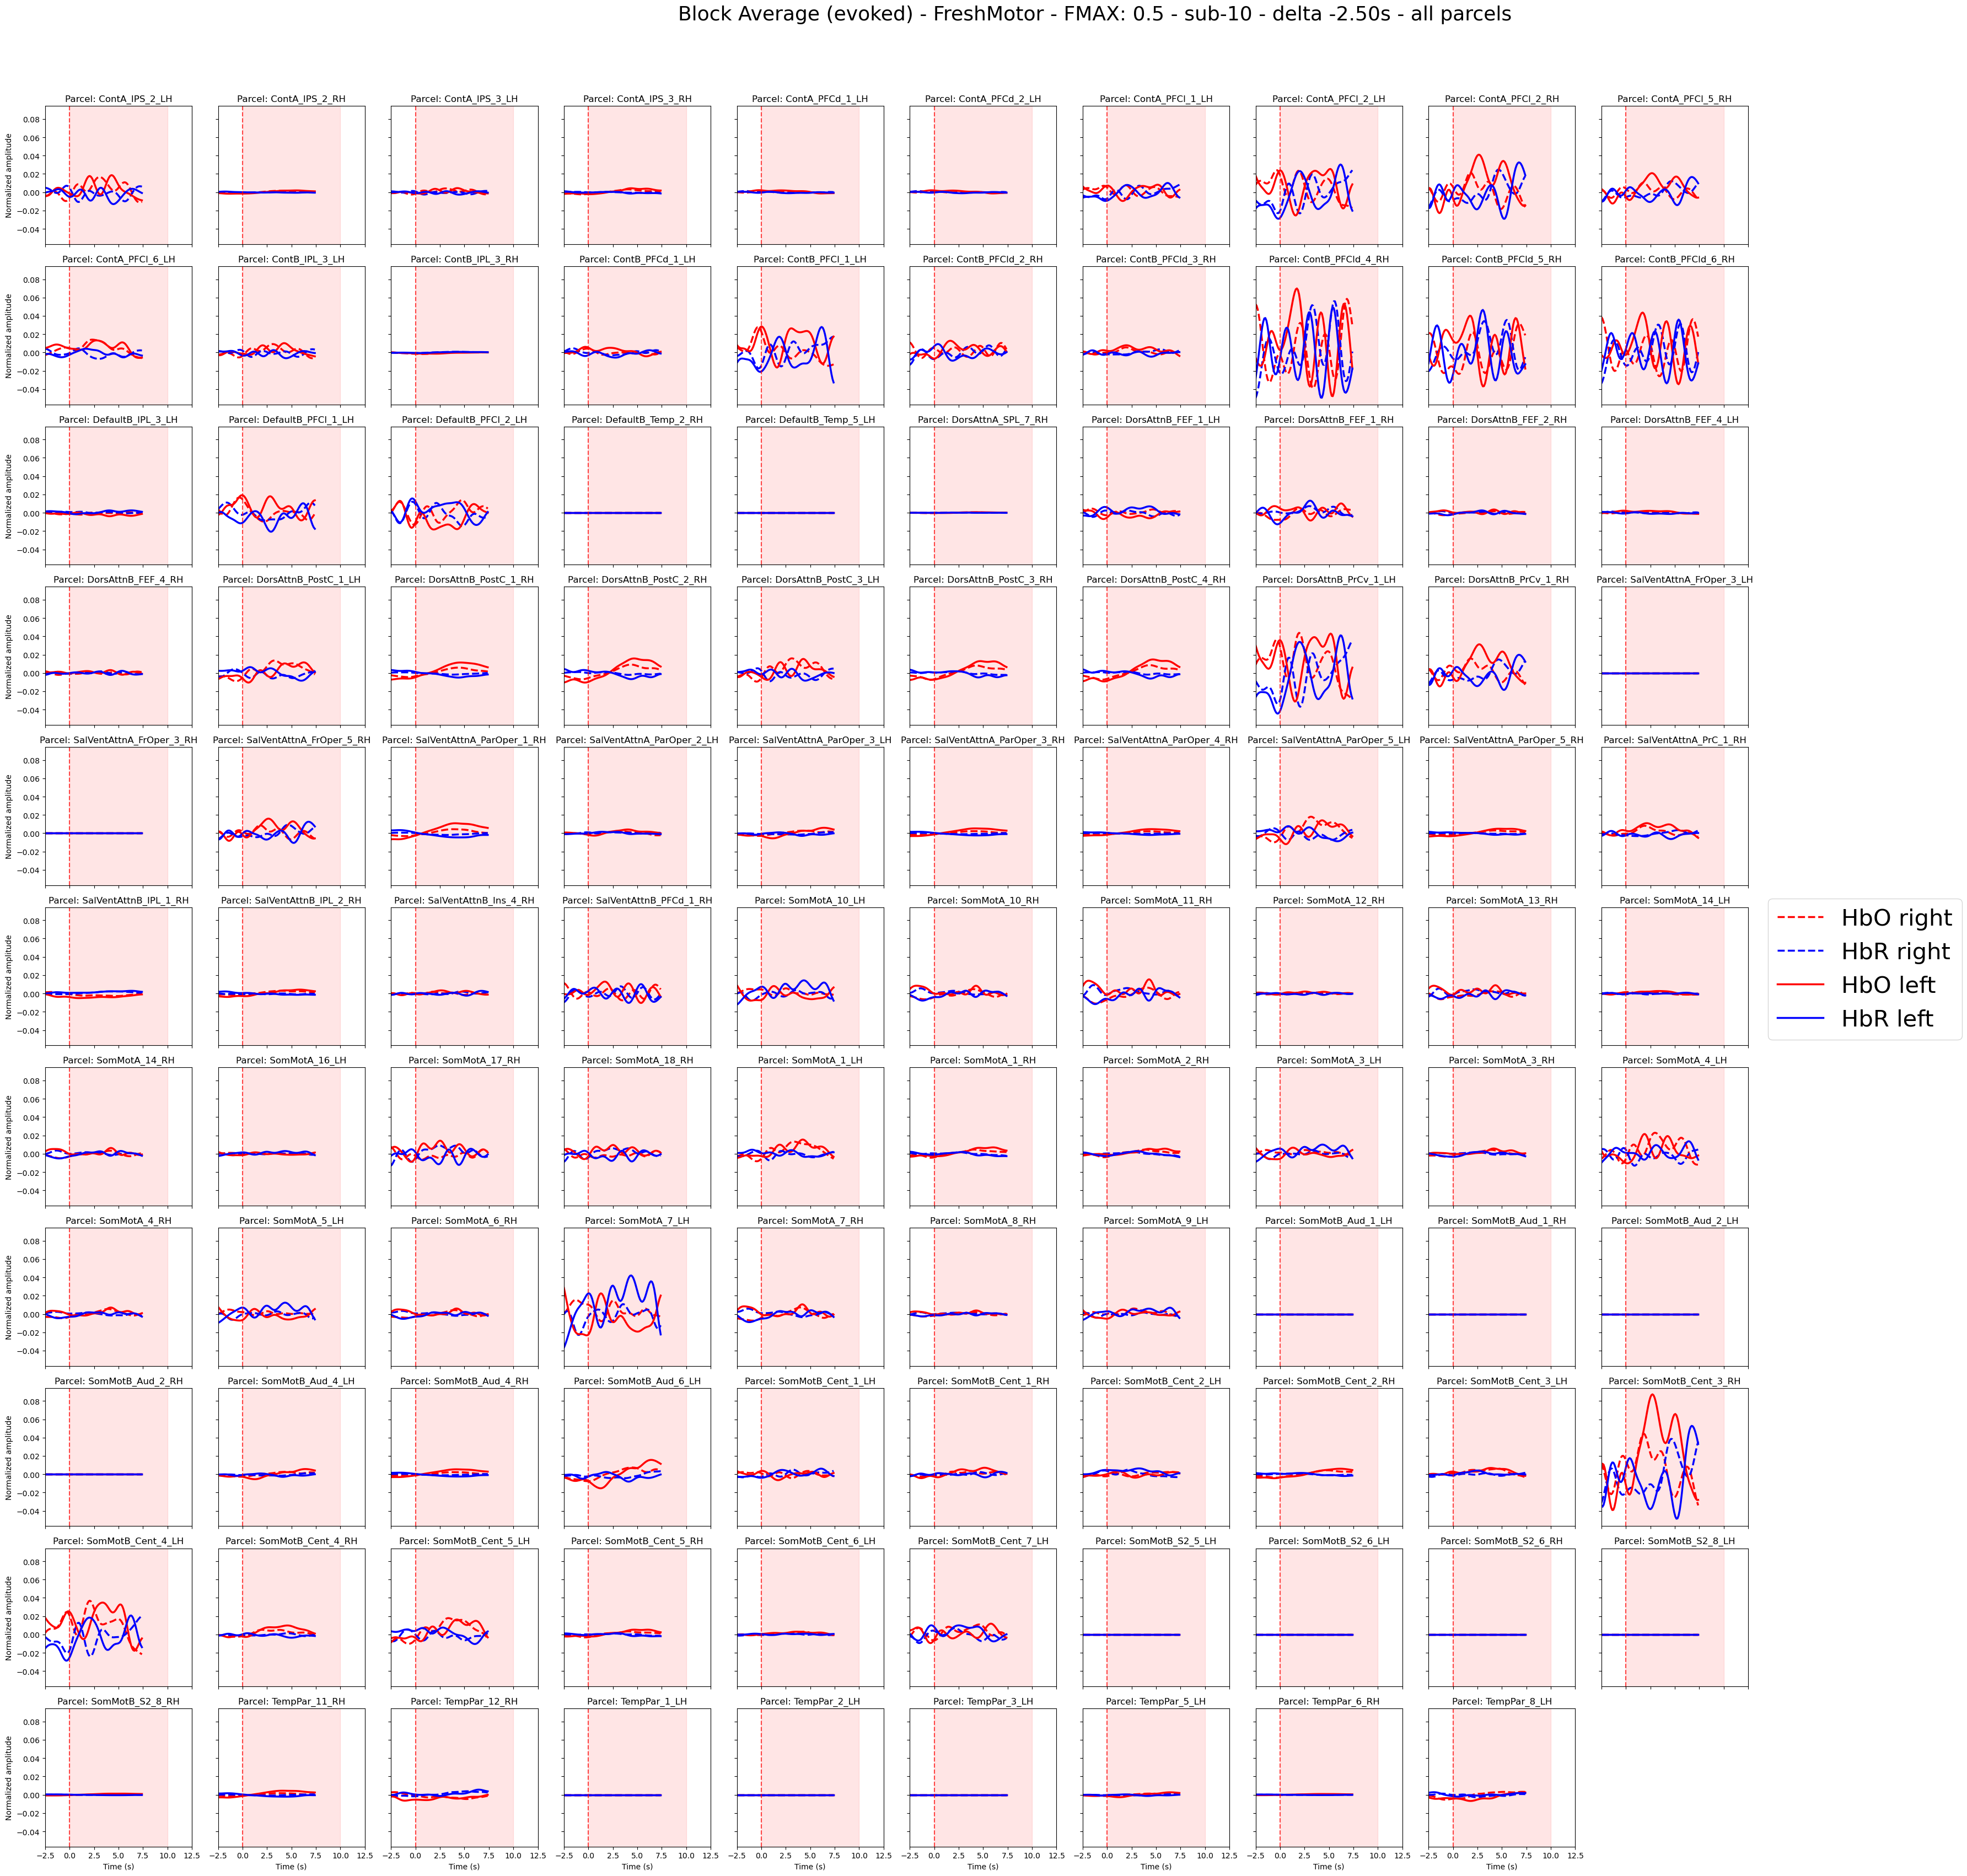

In [28]:
# -------------------------------------------------------------
# Grid of parcel-wise block averages for a given delta
# -------------------------------------------------------------
FMAX = 0.5
# subject_id = 'sub-1'  #'sub-177'
target_delta = -2.5  # seconds
# parcel_indices = [0, 5, 10, 15, 20, 25]
parcel_indices = list(range(len(parcel_template)))

n_cols = 10
freq_dir = Path(PROCESSED_DIR / f'frq{FMAX}')
delta_tag = f"delta{target_delta:+.2f}"
segment_files = sorted((freq_dir / subject_id).glob(f'event_*_{delta_tag}_*.pkl'))
if not segment_files:
    raise ValueError(f'No segments found for delta {target_delta} in {subject_id}')

label_map = {0: 'rest', 1: 'right', 2: 'left'}
segments_by_class = {k: [] for k in label_map}
fs = None
parcel_template = None
TIME_SEGMENT = None
for seg_path in segment_files:
    with open(seg_path, 'rb') as handle:
        seg = pickle.load(handle)
    class_id = seg['class']
    if class_id not in segments_by_class:
        continue
    if fs is None:
        with open(seg['file'], 'rb') as handle:
            orig = pickle.load(handle)
        fs = float(orig['fs'])
        TIME_SEGMENT = seg['TIME_SEGMENT']
        parcel_template = seg['parcel_template']
    segments_by_class[class_id].append(seg['xt'])

trial_duration = TIME_SEGMENT / fs
sample_axis = np.arange(TIME_SEGMENT)
time_axis = target_delta + sample_axis / fs
pad = abs(target_delta)
n_rows = int(np.ceil(len(parcel_indices) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)
fig.suptitle(f'Block Average (evoked) - {DATASET_NAME} - FMAX: {FMAX} - {subject_id} - delta {target_delta:+.2f}s - all parcels', fontsize=26, y=1.03)
axes = axes.flatten()
for ax_idx, ax in enumerate(axes):
    if ax_idx >= len(parcel_indices):
        ax.axis('off')
        continue
    parcel_idx = parcel_indices[ax_idx]
    for class_id, imgs in segments_by_class.items():
        if not imgs:
            continue
        traces = np.stack(imgs)
        hbO_mean = traces[:, 0, parcel_idx, :].mean(axis=0)
        hbR_mean = traces[:, 1, parcel_idx, :].mean(axis=0)
        if class_id == 1:
            line_style = '--'
        elif class_id == 2:
            line_style = '-'
        else:
            line_style = ':'
        ax.plot(time_axis, hbO_mean, color='red', linestyle=line_style, label=f"HbO {label_map[class_id]}", linewidth=2.5)
        ax.plot(time_axis, hbR_mean, color='blue', linestyle=line_style, label=f"HbR {label_map[class_id]}", linewidth=2.5)
    ax.axvspan(0.0, trial_duration, color='red', alpha=0.1)
    ax.axvline(0.0, color='red', linestyle='--', alpha=0.7)
    ax.set_xlim(-pad, trial_duration + pad)
    title = parcel_template[parcel_idx] if parcel_template is not None else f'Parcel {parcel_idx}'
    ax.set_title(f'Parcel: {title}')

for ax in axes[n_cols * (n_rows - 1):]:
    if ax.has_data():
        ax.set_xlabel('Time (s)')
for ax in axes[::n_cols]:
    if ax.has_data():
        ax.set_ylabel('Normalized amplitude')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.8, 0.5), fontsize=30)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig(PROCESSED_DIR / f'grid_block_average_{DATASET_NAME}_{subject_id}_{delta_tag}.png', dpi=300)
plt.show()
